In [0]:
# setup environment
import google.colab
!pip install kappamodules
!pip install torch_geometric

In [0]:
# torch_cluster often doesnt support newest pytorch version which is by default installed in colab -> install older one
!pip install torch==2.3.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# install torch_scatter
!pip install torch_scatter torch_cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

In [0]:
# check successful setup
import torch
print(torch.__version__)
device = torch.device("cuda")
torch.cuda.get_device_name(device)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr

In [0]:
# clone repo
!git clone https://github.com/BenediktAlkin/upt-minimal.git
%cd upt-minimal

# 1 Preliminaries

This notebook will give you an introduction to the basics needed for understanding Universal Physics Transformers (UPT).
- Sparse tensors
- Positional Encoding
- Architecture Overview
  - Encoder
  - Approximator
  - Decoder

We recommend to familiarize yourself with the following papers if you haven't already:
- [Transformer](https://arxiv.org/abs/1706.03762)
- [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
- [Perceiver IO](https://arxiv.org/abs/2107.14795)


The following notebooks will start from scratch with a simple image classification example. Then, each consecutive notebook will introduce a new component to the pipeline:
- [CIFAR10 image classification](https://github.com/BenediktAlkin/upt-minimal/blob/main/2_image_classification.ipynb): start from a basic example (regular grid input, scalar output, easy encoder, simple classification decoder)
- [CIFAR10 autoencoder](https://github.com/BenediktAlkin/upt-minimal/blob/main/3_image_autoencoder.ipynb): introduce the perceiver decoder to query at arbitrary positions
- [SparseCIFAR10 image classification](https://github.com/BenediktAlkin/upt-minimal/blob/main/4_pointcloud_classification.ipynb): introduce handling point clouds via sparse tensors and supernode message passing
- [SparseCIFAR10 autoencoder](https://github.com/BenediktAlkin/upt-minimal/blob/main/5_pointcloud_autoencoder.ipynb): introduce handling point clouds as output
- [TODO](https://github.com/BenediktAlkin/upt-minimal/blob/main/TODO.ipynb): train on a single trajectory of our transient flow simulations


As data comes in all shapes and forms, this gradual introduction of components will hopefully give you a more complete overview of how to apply the UPT framework to various tasks.


## 1.1 Sparse tensors

When handling data from irregular grid, the concept of sparse tensors is commonly used because it allows for efficient computations compared to a dense counterpart.

What is a dense tensor? Consider the example of a pointcloud. Lets say we have a set of 5 pointclouds with 10, 100, 1000, 10000 and 100000 points respectively (each point has 3 coordinates). In order to train a neural network on it we need to convert it into a pytorch tensor and process multiple pointclouds at once.

A dense representation would produce a 3D tensor `(batch_size, max_num_points, 3)` where max_num_points is padded to the largest number of points in a single pointcloud for each batch. This would produce a `(5, 100000, 3)` tensor which consists mostly of padded values (our 5 pointclouds consist of 111.110 points, but the dense representation adds 388.890 additional points for padding).

In [2]:
# create pointclouds
import torch
point_clouds = [
    torch.randn(10, 3),
    torch.randn(100, 3),
    torch.randn(1000, 3),
    torch.randn(10000, 3),
    torch.randn(100000, 3),
]

In [3]:
# make a dense tensor representing of all point clouds
from torch.nn.utils.rnn import pad_sequence
dense = pad_sequence(point_clouds, batch_first=True)
print(f"dense.shape: {dense.shape}")

dense.shape: torch.Size([5, 100000, 3])


In [4]:
# make a sparse tensor representation of all point clouds
sparse = torch.concat(point_clouds)
print(f"sparse.shape: {sparse.shape}")

sparse.shape: torch.Size([111110, 3])


A sparse representation does not require this additional overhead as it simply produces a 2D tensor where the first dimension "squashes" the `batch_size` and `num_points` dimension into one, i.e. it would produce a tensor of shape (111.110, 3). Much smaller better than the dense representation and no additional padding needed. But which point belongs to which pointcloud? In order to preserve this representation, an additional tensor is created that stores which index of the sparse tensor belongs to which pointcloud. This tensor is commonly called `batch_idx`

In [5]:
# create batch_idx tensor to assign indices of the sparse tensor to indices of the pointcloud
batch_idx = []
for i in range(len(point_clouds)):
    batch_idx += [i] * len(point_clouds[i])
batch_idx = torch.tensor(batch_idx)
print(f"batch_idx.shape: {batch_idx.shape}")
print(f"the first 10 samples belong to the first pointcloud (i.e. point_clouds[0]): {batch_idx[:10]}")
print(f"the 11th point in the sparse tensor belongs to the second pointcloud (i.e. point_clouds[1]): {batch_idx[10]}")

batch_idx.shape: torch.Size([111110])
the first 10 samples belong to the first pointcloud (i.e. point_clouds[0]): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
the 11th point in the sparse tensor belongs to the second pointcloud (i.e. point_clouds[1]): 1


Dense tensors are very nice for things like regular grid data (images, videos, ...) but for data from irregular grids, sparse tensors are needed for efficient processing.

In UPTs, the input and output are both sparse tensors but within the model, the tensors are converted from sparse to dense and then back to sparse. That is because message passing layers use a sparse representation and transformers use a dense representation.

## 1.2 Positional Encoding

Positional encodings are a good way to encode 1D, 2D or 3D positional vectors for neural networks to process them. They are commonly used in transformers and make use of sine and cosine waves of different frequencies.

We use the the positional embedding from the original [transformer](https://arxiv.org/abs/1706.03762) paper, which was designed for language modeling, i.e. 1D positions where the smallest position is 0 and the largest one depends on the context length and is typically a couple of thousands. In computer vision, this 1D position is used twice, once to encode the x position and once to encode the y position where a common gridsize for [Vision Transformers (ViTs)](https://arxiv.org/abs/2010.11929) is 14x14, so 196 tokens in total. We use the positional encoding of ViTs, so we encode each dimension seperately and concatenate them. For example, a 3D position would encode x, y and z positions seperately with a third of the latent dimension and then concatenate the three encodings. Additionally, as positions in physical systems can be negative, we rescale all positions via min/max normalization to range from 0 to 200.

How does such a positional encoding look? Lets plot it:

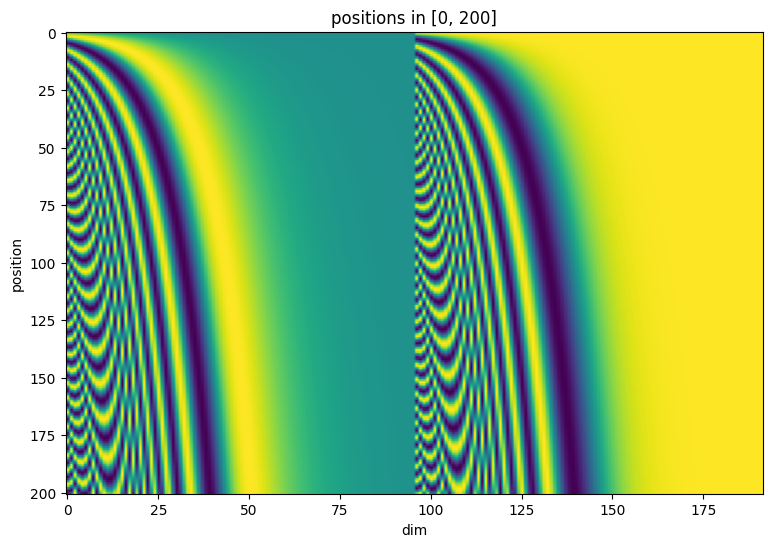

In [6]:
import torch
import matplotlib.pyplot as plt
from kappamodules.layers.continuous_sincos_embed import ContinuousSincosEmbed
# positions in range [0, 200]
pos = torch.linspace(0, 200, 201)
# the embeddings have dimension 192
embed = ContinuousSincosEmbed(dim=192, ndim=1)
# embed the positions
posembed = embed(pos.unsqueeze(0).unsqueeze(2)).squeeze(2).squeeze(0)
# plot it
plt.rcParams['figure.figsize'] = (9, 6)
plt.imshow(posembed, aspect="auto")
plt.xlabel("dim")
plt.ylabel("position")
plt.title(f"positions in [{int(pos.min().item())}, {int(pos.max().item())}]")
plt.show()

## 1.3 Architecture Overview

First, lets have a more detailed look at the architecture. In this tutorial, we will not consider inverse encoding/decoding (to enable the latent rollout) as it adds a lot of complexity to the model. Conceptually, the seperation into encoder/approximator/decoder is only relevant when using a latent rollout, but we stick to this seperation for consistency.

We have a simple transformer based model which we conceptually split into 3 components: encoder, approximator and decoder. We use transformer blocks as the main component in our model (e.g. 12 transformer blocks) which we split evenly across encoder, approximator and decoder.

![Architecture Schematic](https://raw.githubusercontent.com/BenediktAlkin/upt-tutorial/refs/heads/main/schematics/architecture.svg)

### 1.3.1 Encoder

The **encoder** processes input features (e.g. velocities, pressure, ...) and input positions at timestep $t$ and
encodes it into a latent representation $\text{latent}_t$. Input features and input positions are sparse tensors.
The input features are first processed with a shallow MLP. Then, the input positions are added to the result of the
MLP. This representation is then used for a message passing, where messages are only passed to selected supernodes.
We randomly select a fixed number nodes from each pointcloud during dataloading which are then used as "supernodes".


In [7]:
# create some input features and positions
import torch
# create 16 points with 4 features each
input_feat = torch.randn(16, 4)
# 3D coordinates (scaled to be in [0, 200])
input_pos = torch.rand(16, 3) * 200
# create batch_idx (we assume 2 point clouds with length 6 and 10)
batch_idx = torch.tensor([0] * 6 + [1] * 10)
# select 2 supernodes per pointcloud
supernode_idxs = torch.tensor([0, 2, 9, 13])

In [8]:
from upt.modules.supernode_pooling import SupernodePooling
supernode_pooling = SupernodePooling(
    # use a large radius because we dont have a lot of points
    radius=100,
    # max_degree is not relevant here because we have too little points
    max_degree=32,
    # same as dimension of input_feat
    input_dim=4,
    # we use a small hidden dimension for the MLP here
    hidden_dim=8,
    # same as dimension of input_pos
    ndim=3,
)

supernodes = supernode_pooling(
    input_feat=input_feat,
    input_pos=input_pos,
    supernode_idxs=supernode_idxs,
    batch_idx=batch_idx,
)
print(f"supernodes.shape: {supernodes.shape}")

supernodes.shape: torch.Size([2, 2, 8])


Since the number of supernodes is fixed per pointcloud, the supernode pooling can seamlessly output a dense tensor which is then used for processing the supernodes further with some transformer blocks (we use a pre-norm architecture).

In [9]:
# create 4 transformer blocks
from kappamodules.transformer import PrenormBlock
blocks = [PrenormBlock(dim=8, num_heads=2) for _ in range(4)]

# process supernodes with transformer
transformed_supernodes = supernodes
for block in blocks:
    transformed_supernodes = block(transformed_supernodes)
print(f"transformed_supernodes.shape: {transformed_supernodes.shape}")

transformed_supernodes.shape: torch.Size([2, 2, 8])


Optionally, a "Perceiver Pooling" layer can be applied as last layer of the encoder. This layer reduces the number of supernodes into a fixed number of latent tokens. If the "Perceiver Pooling" is not used, the number of latent tokens is equivalent to the number of supernodes.

![Perceiver Pooling Schematic](https://raw.githubusercontent.com/BenediktAlkin/upt-tutorial/refs/heads/main/schematics/perceiver_pooling.svg)

In [10]:
# create perceiver block
from kappamodules.transformer import PerceiverBlock
# create query (this is a learnable vector later on)
# we use 2 latent tokens here
query = torch.randn(1, 2, 8)
encoder_perceiver = PerceiverBlock(dim=8, num_heads=2)
latent_tokens = encoder_perceiver(q=query, kv=transformed_supernodes)
print(f"latent_tokens.shape: {latent_tokens.shape}")

# the same thing can be done in one go
from kappamodules.transformer import PerceiverPoolingBlock
encoder_perceiver_onego = PerceiverPoolingBlock(num_query_tokens=2, dim=8, num_heads=2)
latent_tokens_onego = encoder_perceiver_onego(kv=transformed_supernodes)
print(f"latent_tokens_onego.shape: {latent_tokens_onego.shape}")


latent_tokens.shape: torch.Size([2, 2, 8])
latent_tokens_onego.shape: torch.Size([2, 2, 8])


### 1.3.2 Approximator

The approximator takes the `latent_tokens` and pushes them forward by one timestep. It simply consists of some transformer blocks.

In [11]:
from kappamodules.transformer import PrenormBlock
approximator = torch.nn.Sequential(*[PrenormBlock(dim=8, num_heads=2) for _ in range(4)])
latent_tokens_next_timestep = approximator(latent_tokens)
print(f"latent_tokens_next_timestep.shape: {latent_tokens_next_timestep.shape}")


latent_tokens_next_timestep.shape: torch.Size([2, 2, 8])


### 1.3.2 Decoder

The decoder takes the latent_tokens and decodes them into the original space of the input data. It does this by querying the latent space at arbitrary positions. It first employs some transformer blocks, followed by a perceiver decoder block. The output positions are encoded via a shallow MLP before being used as query vector for the perceiver. 

![Perceiver Decoder Schematic](https://raw.githubusercontent.com/BenediktAlkin/upt-tutorial/refs/heads/main/schematics/perceiver_decoder.svg)

For training, the output positions need to have an associated ground truth value in the dataset as the model is trained via an mean-squared-error loss between the predictions at the output positions and the ground truth value at the output positions. For inference, the output positions can be arbitrary. Also: output positions and input positions do not have to match (also not during training).

In [12]:
# create some output positions (we query at 4 positions per pointcloud)
import torch
# (2=number of pointclouds, 4=number of output positions, 3=3D positions)
output_pos = torch.randn(2, 4, 3)

# some transformer blocks
from kappamodules.transformer import PrenormBlock
decoder_transformer = torch.nn.Sequential(*[PrenormBlock(dim=8, num_heads=2) for _ in range(4)])

# create perceiver
from kappamodules.transformer import PerceiverBlock
decoder_perceiver = PerceiverBlock(dim=8, num_heads=2)

# create positional encoding and MLP to encode positions
from kappamodules.layers import ContinuousSincosEmbed
pos_embed = ContinuousSincosEmbed(dim=8, ndim=3)
output_pos_mlp = torch.nn.Sequential(
    torch.nn.Linear(8, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 8),
)

In [13]:
# apply transformer
decoder_perceiver_kv = decoder_transformer(latent_tokens_next_timestep)

# encode output positions into query vector
query = output_pos_mlp(pos_embed(output_pos))

# apply perceiver decoder
pred = decoder_perceiver(q=query, kv=decoder_perceiver_kv)

print(f"decoder_perceiver_kv.shape: {decoder_perceiver_kv.shape}")
print(f"query.shape: {query.shape}")
print(f"pred.shape: {pred.shape}")

decoder_perceiver_kv.shape: torch.Size([2, 2, 8])
query.shape: torch.Size([2, 4, 8])
pred.shape: torch.Size([2, 4, 8])
